In [1]:
import sys
ROOT_DIR = ".."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [2]:
import os
import time
import numpy as np
import six
import itertools
import h5py as h5
from mpi4py import MPI # module required to use MPI
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pysingfel as ps
import pysingfel.gpu as pg
from pysingfel.util import asnumpy, xp

In [3]:
beam = ps.Beam(ROOT_DIR+'/input/beam/amo86615.beam')

In [4]:
#det = ps.Epix10kDetector(geom=ROOT_DIR+'/input/lcls/xcslt4017/Epix10ka2M::CalibV1/XcsEndstation.0:Epix10ka2M.0/geometry/7-end.data',run_num=7,beam=beam)

In [5]:
det = ps.Epix10kDetector(geom=ROOT_DIR+'/input/lcls/xcsx35617/Epix10ka2M::CalibV1/XcsEndstation.0:Epix10ka2M.0/geometry/0-end.data',beam=beam)

In [6]:
# reset detector distance for desired resolution
# aim for 5A to 7A resolution
det.distance *= 0.25

In [7]:
particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/input/pdb/2CEX.pdb', ff='WK')

('Unknown element or wrong line: \n', 'HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  \n')


In [8]:
experiment = ps.SPIExperiment(det, beam, particle)

In [9]:
def demo(experiment):
    """Plot a few slices of the experiment."""
    Nrows = 1  # <- Modify this constant to have more/less images.
    viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    plt.figure(figsize=(20, 4.5*Nrows-0.5))
    start = time.clock()
    for i in range(4*Nrows):
        plt.subplot(Nrows, 4, i+1)
        img = experiment.generate_image()
        viz.imshow(img)
    stop = time.clock()
    plt.show()
    rate = 4 * Nrows / (stop - start)
    print("Image rate = {:.5f} images per second.".format(rate))

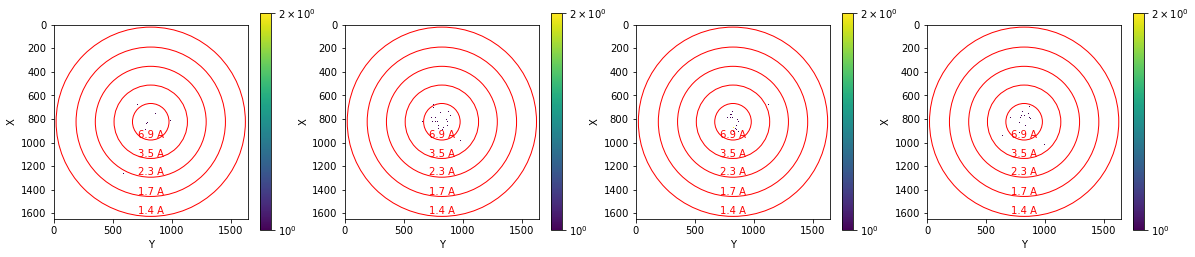

Image rate = 0.15015 images per second.


In [10]:
demo(experiment)

### GAIN_MODES = ['FH','FM','FL','AHL-H','AML-M','AHL-L','AML-L']

In [11]:
det.pedestals.shape

(7, 16, 352, 384)

In [12]:
import pyimgalgos.NDArrGenerators as ag

peds = []
for i in range(det.pedestals.shape[1]):
    nda = ag.random_standard(shape=det.pedestals.shape[2:], mu=np.mean(det.pedestals[2]), sigma=np.mean(det.pixel_rms[2]), dtype=np.float)
    peds.append(nda)
peds = np.array(peds)

## Bitshifting

In [13]:
# pixel value is stored as uint16
# highest 2 bits store gainbit, i.e. (low: 0 or 0b00, middle: 1 or 0b01, high: 2 or 0b10)
# lower 14 bits store diffraction intensity, i.e. maximum intensity value is 2**14-1 = 16,383
nBits = 14 # numIntensityBits
maxEnergy = 10000*8 ## keV
nRanges = 2 # numGainBits
maxIntensity = 2**nBits-1
switchPoints = [-666, maxEnergy*666] ## keV
switchPointVariations = [4.*8, 0.] ## keV, placeholder
switchPointWidths = [4.*8, 0.] ## keV, placeholder
offsets = [0, 2100] ## ADU, placeholder
gains = [4.1, 0.1] ## ADU/keV
gainErrors = [0.01, 0.015] ## dimensionless, placeholder
nonLinearity = [0.01/2400, 0.017/maxEnergy] ## 1/keV, placeholder

detDim = (16, 352, 384)
gainbit = np.zeros(detDim)

# pedestal correction substracts a pedestal --> add pedestal
adu = (experiment.generate_image_stack()+peds).astype('uint16')

def ADUtoGainbit(x):
    if x < -666:
        return 0
    elif -666 < maxEnergy*666:
        return 1

vecfunc = np.vectorize(ADUtoGainbit)
gainbit = vecfunc(adu)

# gain correction divides by gainbit --> multiply gainbit
adu = np.multiply(adu,gainbit)
raw = np.left_shift(gainbit,nBits) + adu # combine 2-bit gainbit and 14-bit adu in a single 16-bit array to save memory

In [14]:
import psana
import numpy as np
import time
import matplotlib.pyplot as plt
from Detector.UtilsEpix10ka import find_gain_mode

#experimentName = 'xcslt4017'
#runNumber = '357'
experimentName = 'xcsx35617'
#runNumber = '99' ## runs 99-107: MEdium gain
runNumber = '421' ## low-gain dark run
detInfo = 'epix10ka2m'
ds = psana.DataSource('exp='+experimentName+':run='+runNumber+':idx')
run = ds.runs().next()
det = psana.Detector(detInfo)
times = run.times()
env = ds.env()

## Apply pedestals + gain corrections

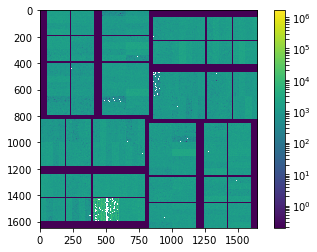

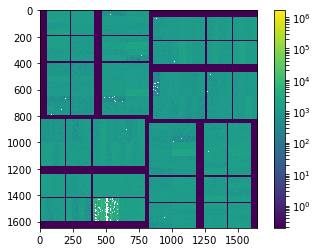

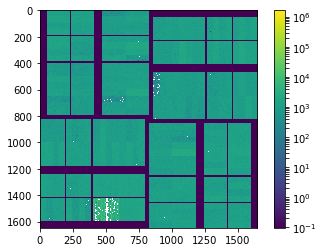

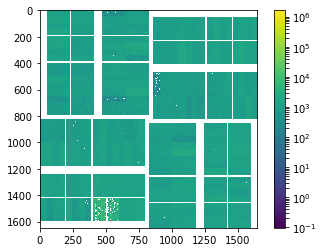

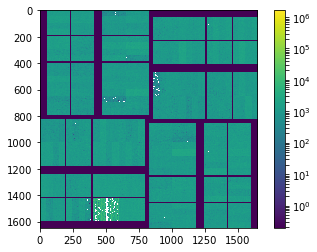

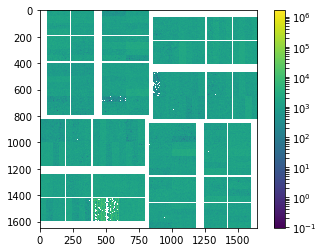

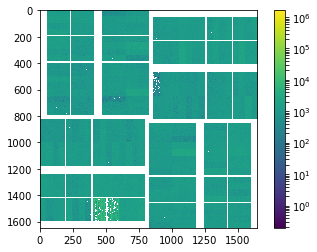

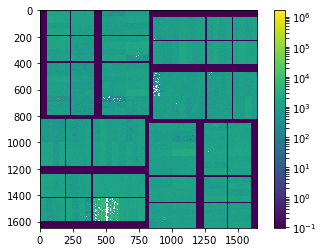

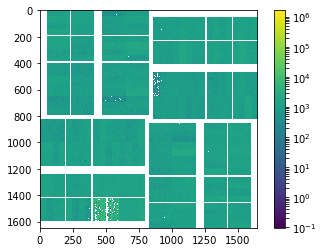

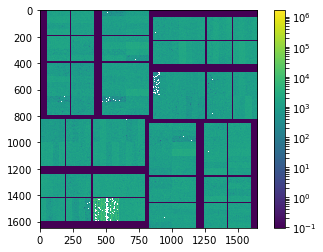

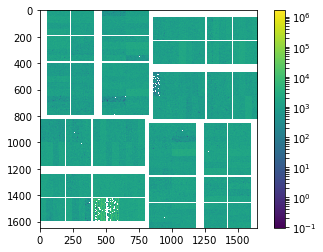

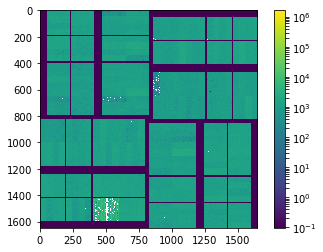

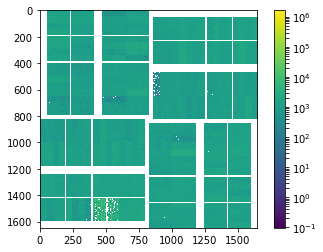

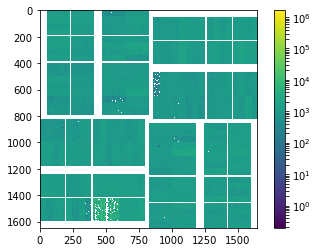

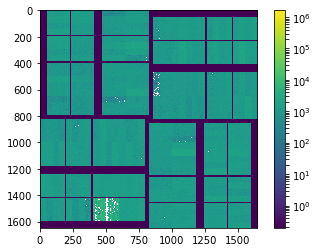

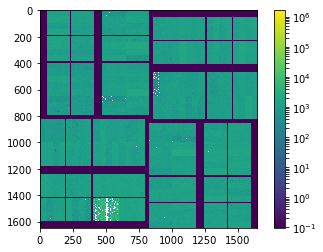

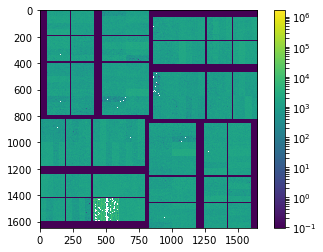

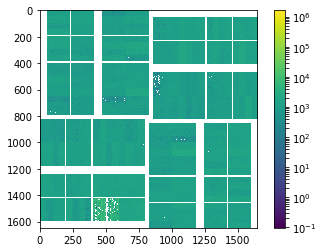

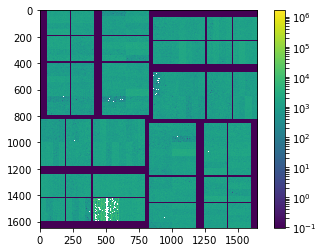

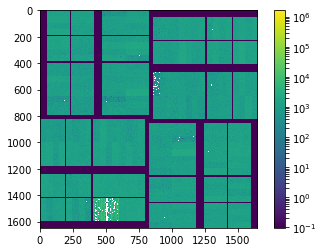

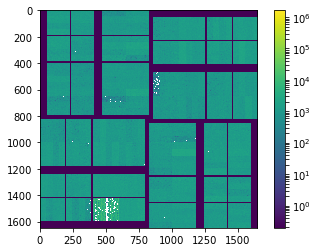

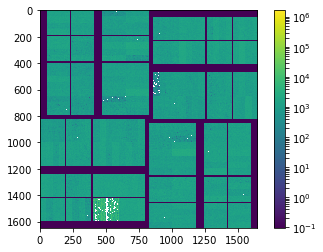

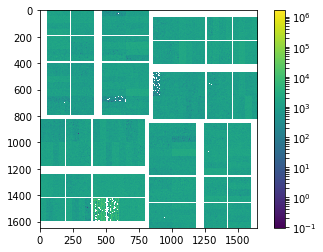

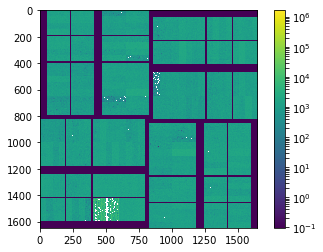

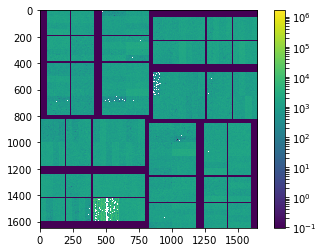

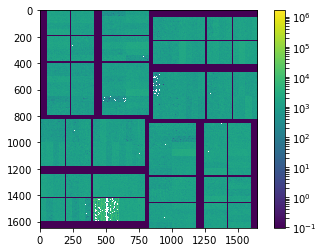

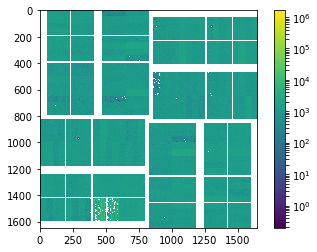

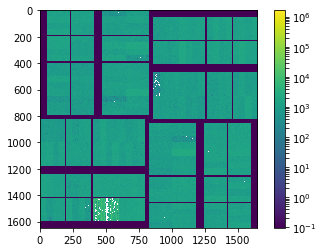

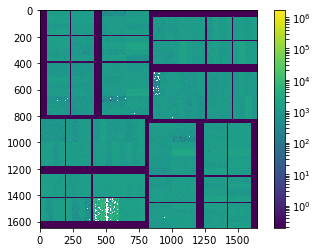

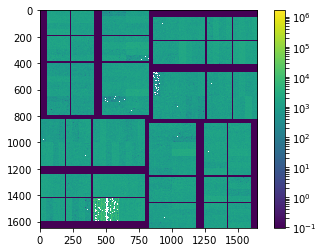

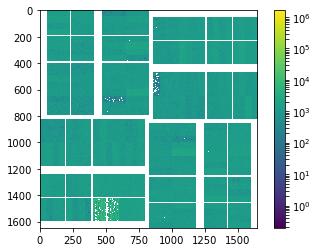

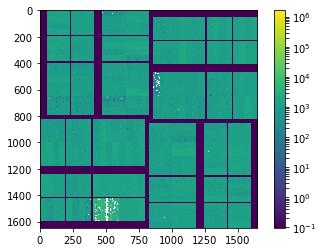

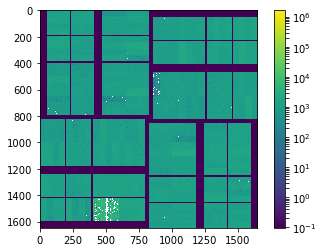

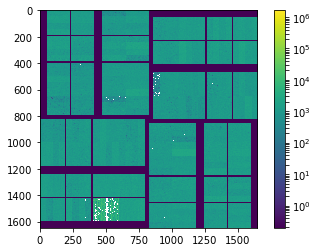

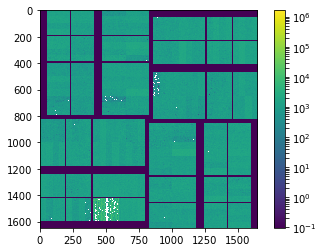

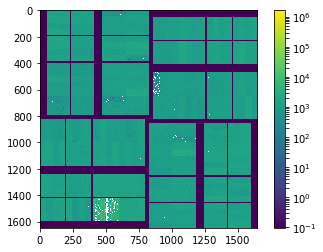

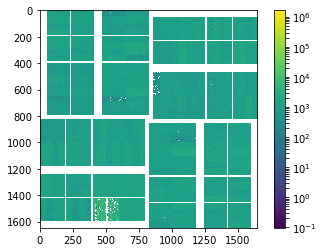

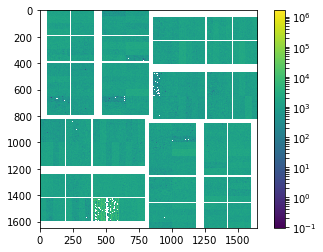

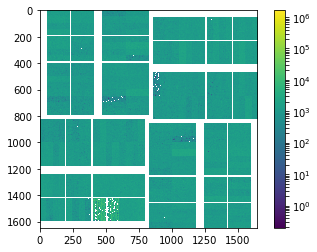

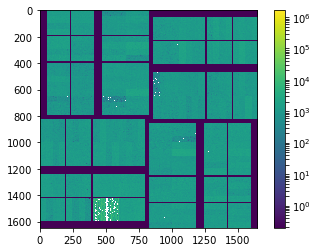

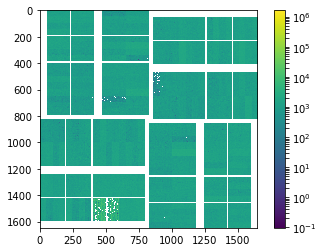

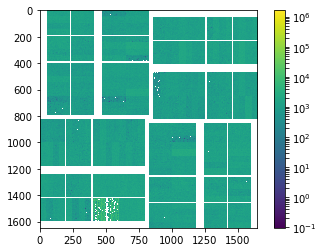

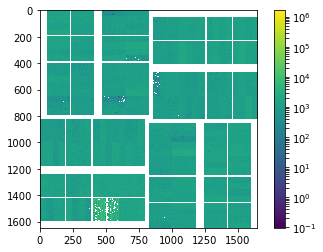

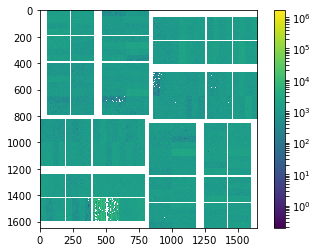

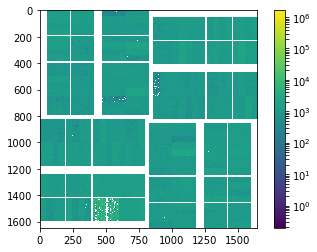

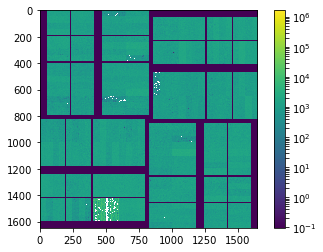

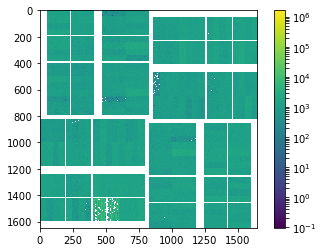

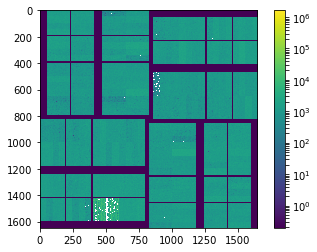

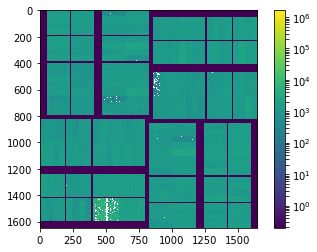

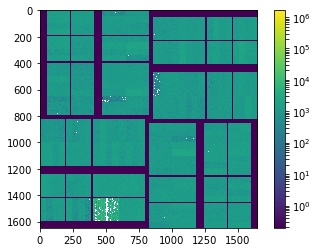

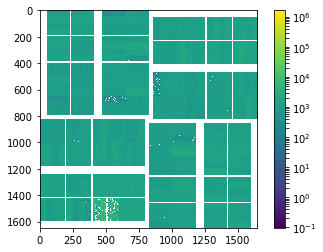

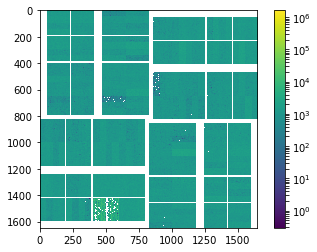

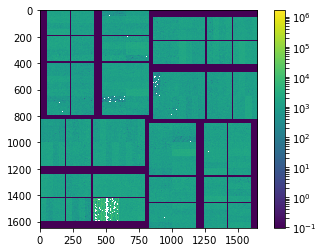

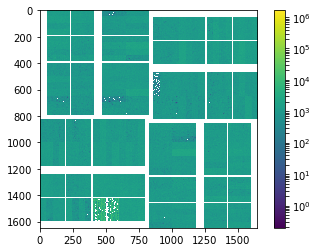

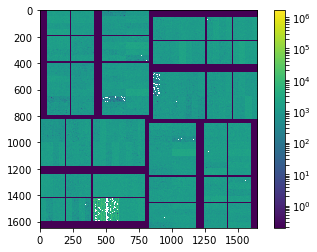

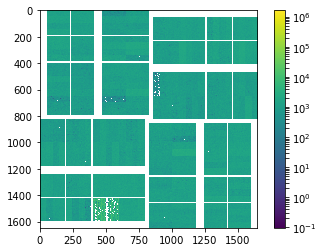

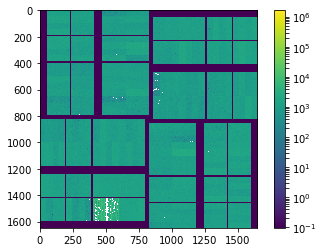

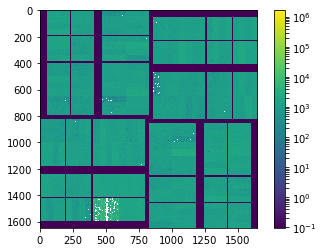

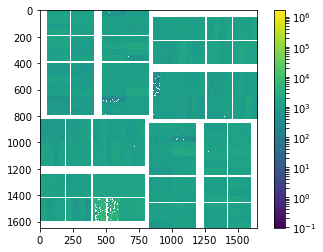

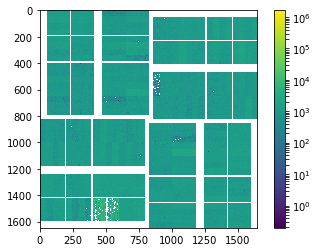

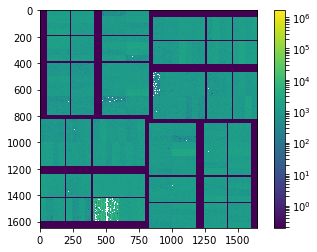

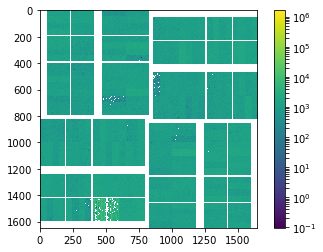

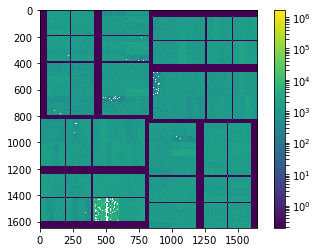

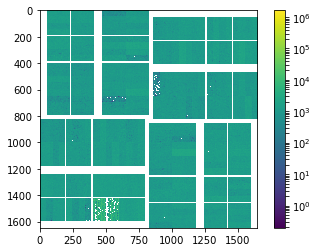

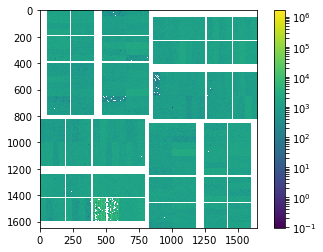

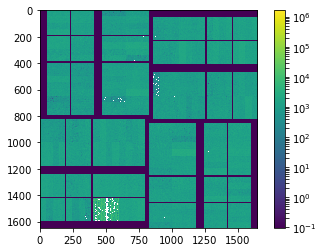

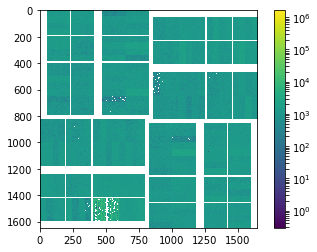

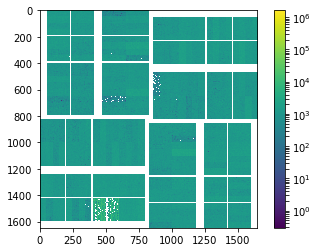

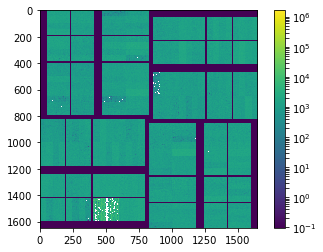

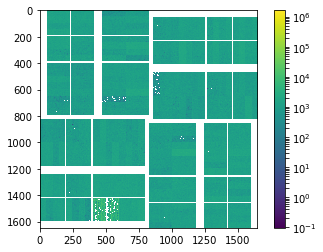

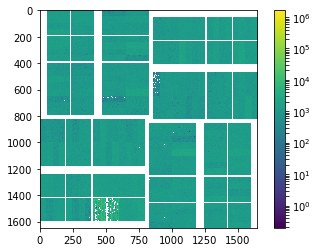

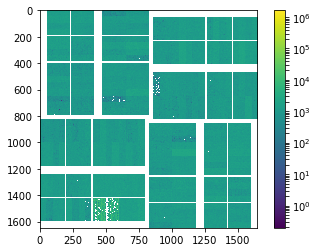

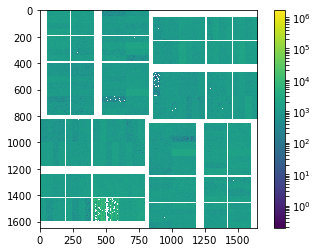

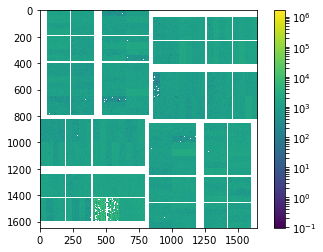

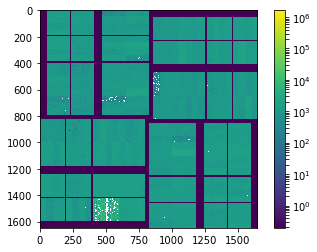

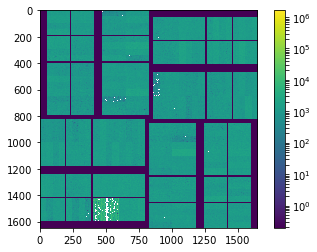

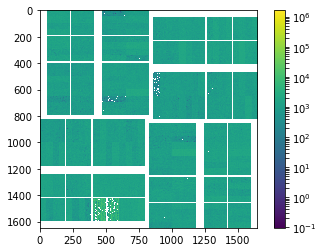

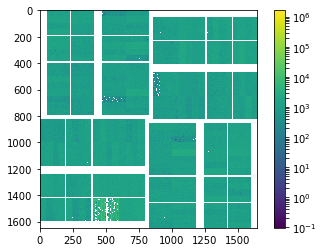

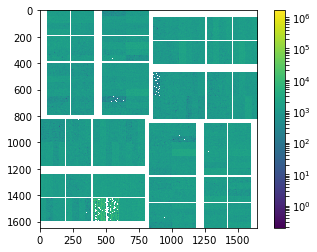

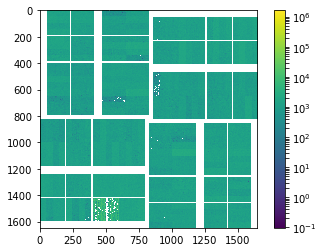

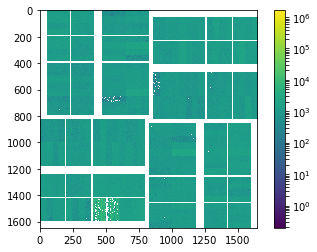

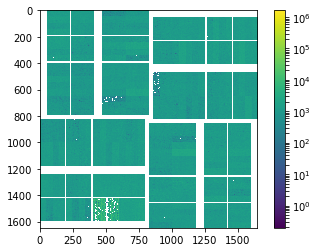

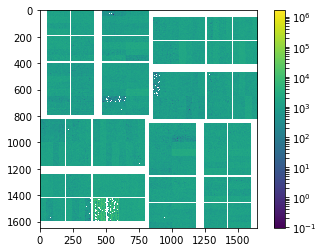

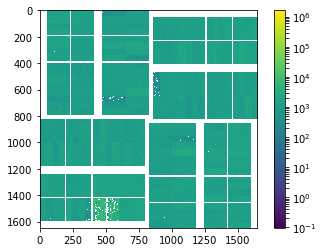

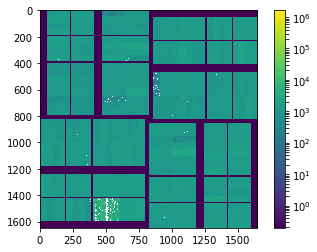

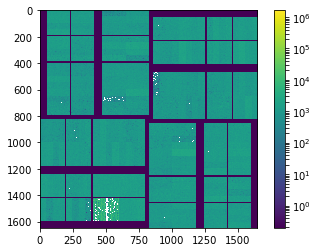

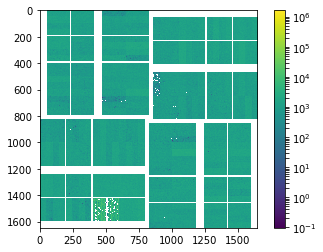

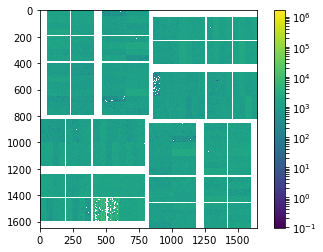

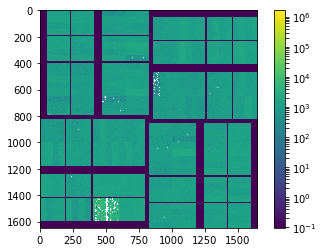

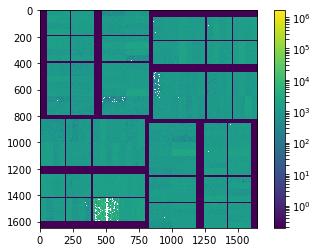

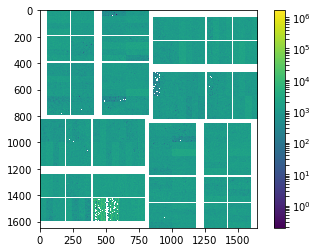

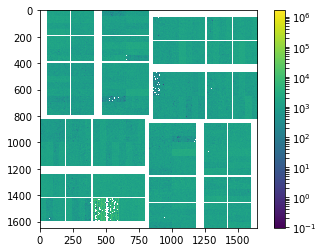

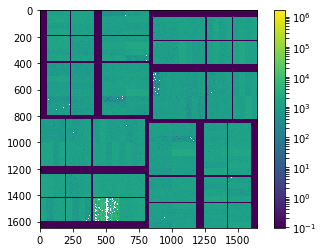

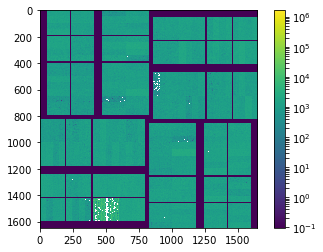

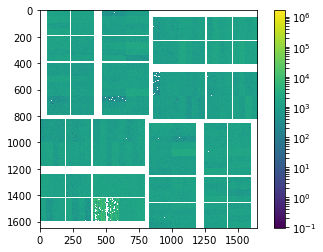

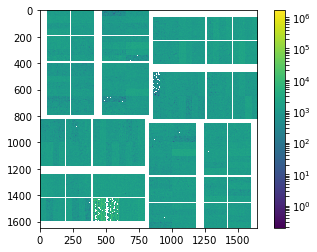

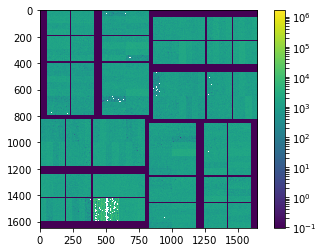

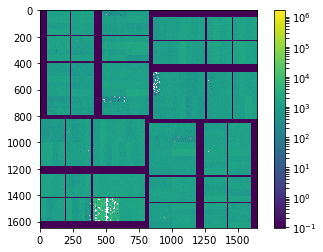

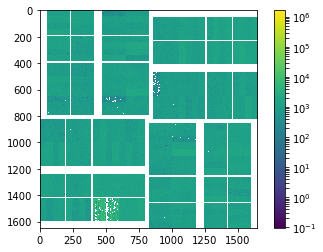

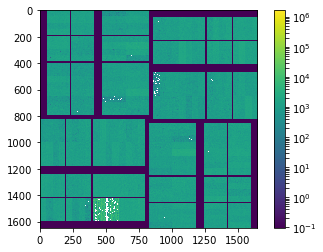

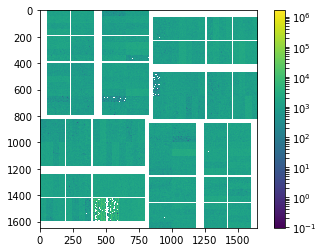

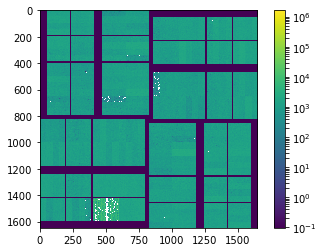

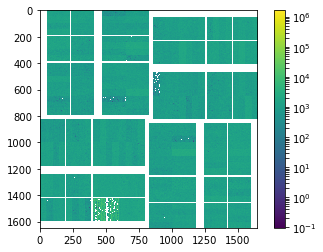

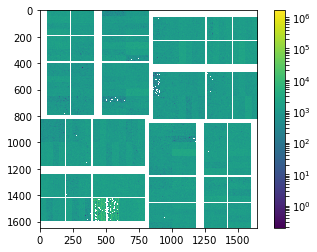

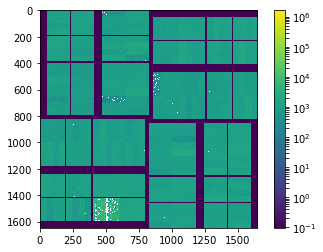

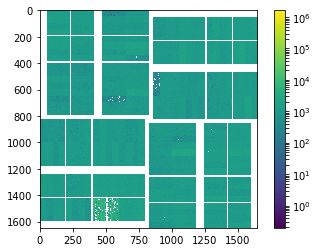

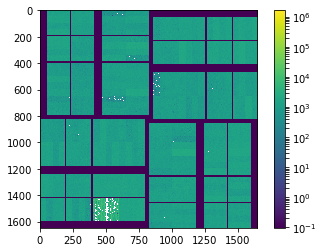

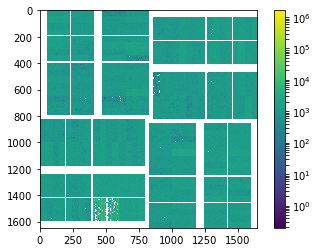

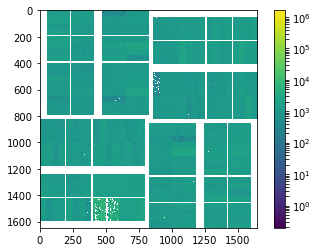

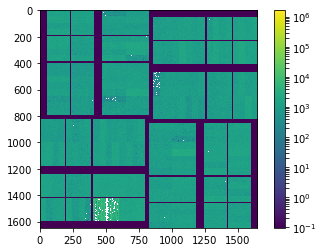

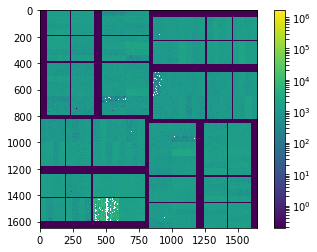

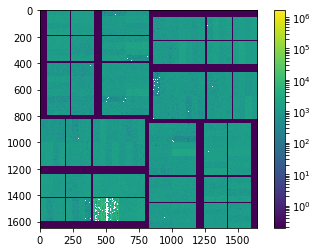

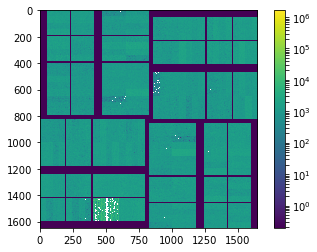

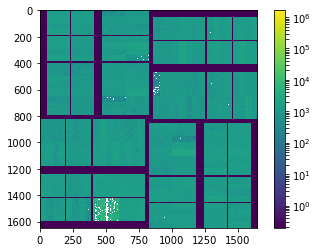

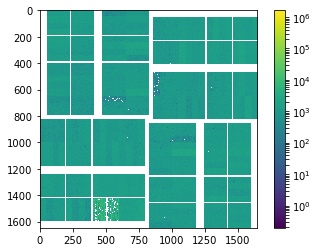

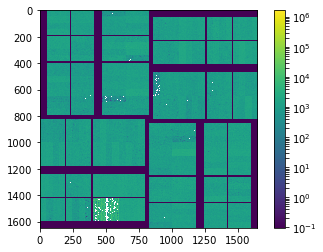

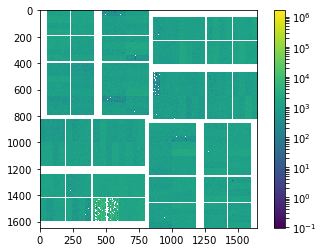

In [ ]:
for i in times:
    evt = run.event(i)
    raw = det.raw(evt)
    #gm = find_gain_mode(det, raw) # returns string name of the gain mode
    #print gm
    calib = det.calib(evt, cmpars=(0,2,100), nda_raw=peds)
    img1 = det.image(evt, calib)
    calib = det.calib(evt, cmpars=(0,2,100), nda_raw=raw)
    img2 = det.image(evt, calib)
    #plt.subplot(1,2,1)
    #plt.imshow(img1, norm=LogNorm())
    #plt.subplot(1,2,2)
    plt.imshow(img2, norm=LogNorm())
    plt.colorbar()
    plt.show()
    #print calib.shape
    #print img1.shape
    #print img2.shape
    exit()